In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
plt.style.use("bioAI.mplstyle")
from plotting_functions import set_size

#from CANN_burak import CANN_burak
#from CANN_sorscher import CANN_sorscher
from CANN_burak_jax import CANN_burak, forward_jit

/home/vemundss/anaconda3/envs/jax/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def init_periodic_recurrent_weights(self, sheet):
    ravel_sheet = jnp.reshape(sheet, (-1, 2))  # (64, 64, 2) -> (64**2, 2)
    ravel_shift = jnp.reshape(self.shift, (-1, 2))
    # compute 'distances'
    d = jnp.abs(ravel_sheet[:, None] - (ravel_sheet + self.l * ravel_shift)[None])
    # compute periodic distances
    periodic_d = jnp.minimum(d, self.nl - d)  # nl is width of box

    papa = jnp.sum(periodic_d ** 2, axis=-1)  # ran out of names
    w0 = jnp.exp(-self.gamma * papa) - jnp.exp(-self.beta * papa)  # DoG
    return w0.reshape((self.nl ** 2, self.nl ** 2))

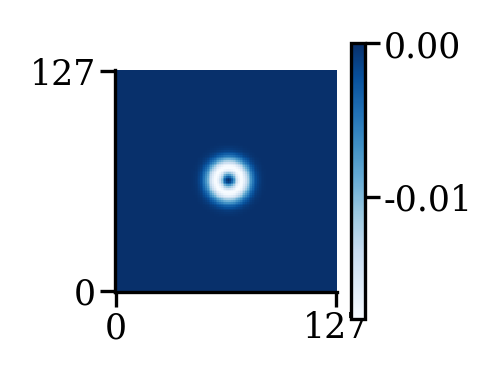

In [4]:
cann = CANN_burak(Ng:=128*128, l=1)
#cann = CANN_burak(Ng:=16*16, l=2)

figsize = set_size(fraction=(1/4,1/4),mode='square')
fig, ax = plt.subplots(figsize=figsize, dpi=300)
im = ax.imshow(cann.wr[cann.nl**2//2+cann.nl//2].reshape(cann.nl,cann.nl), origin='lower') # recurrence weights
#im = ax.imshow(cann.wr[0].reshape(cann.nl,cann.nl), origin='lower') # recurrence weights
#ax.arrow(cann.nl//2, cann.nl//2, *(cann.shift[cann.nl//2,cann.nl//2]*cann.l), head_width=0.1, head_length=0.1, color='orange') # shift
#plt.plot(cann.nl//2, cann.nl//2, 'ro', label='center') # center
#plt.title(r'$w_{ij}$')
ax.set_xticks([0,127])
ax.set_yticks([0,127])
plt.colorbar(im, ax=ax)

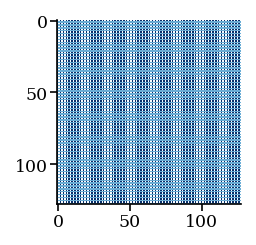

In [5]:
plt.imshow(cann.shift[...,0].reshape(cann.nl,cann.nl))

In [6]:
class RandomWalk2D(object):
    # Simple dataset maker; square box + bounce off walls
    def __init__(self, box_size = 2*np.pi, von_mises_scale = 4*np.pi, rayleigh_scale = 0.15):
        self.box_size = box_size # box_size x box_size enviroment
        self.von_mises_scale = von_mises_scale
        self.rayleigh_scale = rayleigh_scale

    def bounce(self, r, v):
        # bounce off walls if next step lands outside
        outside = np.abs(r + v) >= self.box_size
        v[outside] = -v[outside]
        return v

    def generate_data(self, samples, timesteps, device = "cpu"):
        r = np.zeros((samples, timesteps, 2)) # positions
        s = np.random.rayleigh(self.rayleigh_scale, (samples, timesteps)) # speeds

        # initial conditions
        prev_hd = np.random.uniform(0, 2*np.pi, samples) # previous head direction
        r[:,0] = np.random.uniform(-self.box_size, self.box_size, (samples, 2))

        for i in range(timesteps - 1):
            hd = np.random.vonmises(prev_hd, self.von_mises_scale, samples)
            prop_v = s[:,i,None]*np.stack((np.cos(hd), np.sin(hd)),axis=-1)
            v = self.bounce(r[:,i], prop_v)
            prev_hd = np.arctan2(v[:,1], v[:,0])
            r[:,i+1] = r[:,i] + v

        v = np.diff(r, axis = 1) # velocities
        return np.squeeze(r), np.squeeze(v)

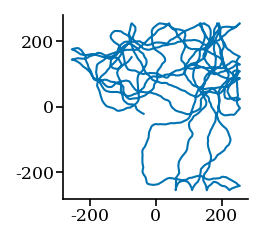

In [7]:
#rw = RandomWalk2D(cann.nl*10, von_mises_scale=400*np.pi, rayleigh_scale=0.2)
rw = RandomWalk2D(cann.nl*10, von_mises_scale=50*np.pi, rayleigh_scale=2)
ntrajectory_steps = 20000
rs, vs = rw.generate_data(1, ntrajectory_steps+1)
eps = 0.2
rs = rs*eps
vs = vs*eps
hn = np.random.uniform(0, 1, size=(Ng,)) # initial hidden state
hs = np.zeros((ntrajectory_steps, Ng))
unit0 = []
plt.plot(*rs.T)

In [8]:
burn_in = 5000
for i in tqdm.trange(burn_in):
        hn = forward_jit(hn, np.zeros(2), cann.wr, cann.shift.reshape(-1, 2), cann.alpha, cann.tc)
hs[0] = np.copy(hn)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [05:20<00:00, 15.62it/s]


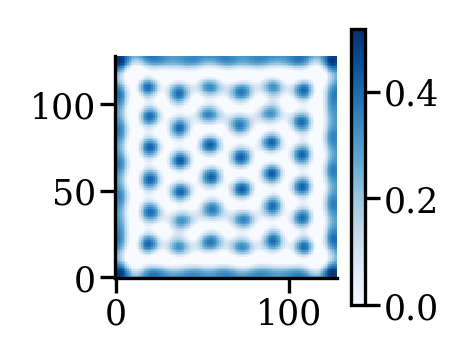

In [9]:
# neural sheet plot
figsize = set_size(fraction=(1/4,1/4),mode='square')
fig, ax = plt.subplots(figsize=figsize, dpi=300)
im = ax.imshow(hn.reshape(cann.nl, cann.nl),origin='lower')#,cmap='coolwarm')
box_view = cann.nl*eps
# plot box of box view in center
#plt.plot([cann.nl//2-box_view/2, cann.nl//2+box_view/2, cann.nl//2+box_view/2, cann.nl//2-box_view/2, cann.nl//2-box_view/2],
#         [cann.nl//2-box_view/2, cann.nl//2-box_view/2, cann.nl//2+box_view/2, cann.nl//2+box_view/2, cann.nl//2-box_view/2],
#         color='black', linestyle='--')
plt.colorbar(im, ax=ax)

In [29]:
#unit = np.zeros((ntrajectory_steps))
#unit[0] = hn[0]
for i in tqdm.trange(i,ntrajectory_steps):
        hn = forward_jit(hn, vs[i], cann.wr, cann.shift.reshape(-1, 2), cann.alpha, cann.tc)
        hs[i] = np.copy(hn)
        #unit[i] = hn[0]

  0%|          | 0/14867 [00:00<?, ?it/s]

  0%|          | 11/14867 [00:01<21:09, 11.70it/s]

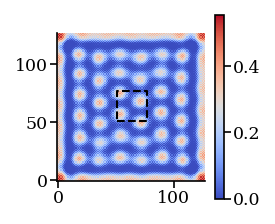

In [26]:
# neural sheet plot
plt.imshow(hn.reshape(cann.nl, cann.nl),cmap='coolwarm',origin='lower')
box_view = cann.nl*eps
# plot box of box view in center
plt.plot([cann.nl//2-box_view/2, cann.nl//2+box_view/2, cann.nl//2+box_view/2, cann.nl//2-box_view/2, cann.nl//2-box_view/2],
         [cann.nl//2-box_view/2, cann.nl//2-box_view/2, cann.nl//2+box_view/2, cann.nl//2+box_view/2, cann.nl//2-box_view/2],
         color='black', linestyle='--')
plt.colorbar()

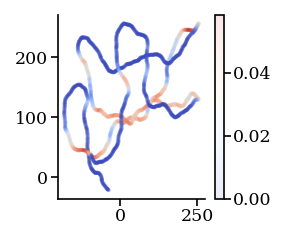

In [27]:
plt.scatter(*rs[:i].T, c=hs[:i,cann.nl**2//2+cann.nl//2], cmap='coolwarm', s=1, alpha=0.1)
#plt.scatter(*rs[:i].T, c=unit[:i], cmap='coolwarm', s=1, alpha=0.1)
#plt.plot(*rs[burn_in:len(unit0)].T)
plt.colorbar()

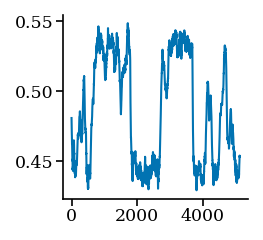

In [28]:
plt.plot(hs[:i,0])
#plt.plot(unit[:i])

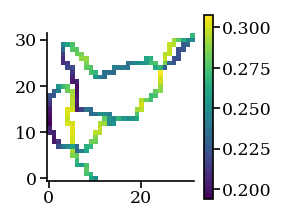

In [24]:
import scipy.stats as stats

ratemap = stats.binned_statistic_2d(*rs[:i].T, hs[:i,cann.nl**2//2+cann.nl//2+700], bins=32)[0]
#ratemap = stats.binned_statistic_2d(*rs[:i].T, unit[:i], bins=32)[0]
plt.imshow(ratemap.T, cmap='viridis', origin='lower')
plt.colorbar()